# Crude Oil Energy Indicators – Datasets and Methodologies

## Importance of Energy Data:
Reliable data is the foundation of informed discussion and decision-making by government, industry, and the Canadian public. It plays a key role in enhancing public confidence, economic competitiveness and the Government’s ability to support a transition to a low-carbon economy.

## Overview of Energy Information in Canada:
Energy information includes statistics, data, analysis and projections related to the production, transformation, distribution and consumption of energy; as well as the inter-relationship between energy and the economy, society and the environment.

Canada's energy information system is a collective contribution of several organizations, including:
- four federal departments or agencies:
  - Natural Resources Canada (NRCAN) [(link)](https://www.nrcan.gc.ca/home);
  - Statistics Canada [(link)](https://www.statcan.gc.ca/eng/start);
  - Environment and Climate Change Canada [(link)](https://www.ec.gc.ca/?lang=En);
  - Canada Energy Regulator (CER) [(link)](https://www.cer-rec.gc.ca/index-eng.html);
- provincial and territorial government departments, regulators and utilities boards;
- energy market participants (ex. power producers, pipeline companies, system operators, etc.);
- industry associations and academic research bodies;
- Canada’ Open Government website [(link)](https://open.canada.ca/en);
- __Canadian Energy Information Portal (launched in June 2019) [(link)](https://www.statcan.gc.ca/eng/topics-start/energy).__

## Canadian Energy Information Portal:
In June 2019, the government of Canada launched the Canadian Energy Information Portal [(link)](https://www.statcan.gc.ca/eng/topics-start/energy). The Portal is a one-stop shop for energy  information that provides a single point of access for all federal government statistics and provides links to existing body of energy information products.

Although Canadian energy information is abundant, it can be difficult to navigate, interpret and verify, particularly for non-experts. Moreover, data measurements, definitions and reporting standards vary amongst information providers. Often, data is not available in structured and machine-readable formats. Finally, data releases are often not timely, and lags are considered too long for a growing demand for real-time information.

## Goal of this notebook: 

- 1) Identify the main dataset featured in Canada’s crude oil __[Energy Indicators](https://www.cer-rec.gc.ca/nrg/tl/nrgcmmdt/nrgndctrlctrct-eng.html)__;
- 2) Load each dataset used in the Energy Indicators into the Jupyter Notebook;
- 3) Chart each dataset;
- 4) Provide links to other publically-available datasets for more analysis.

__Datasets used in the Energy Indicators come from multiple, free, publicly-available sources. Dataset files themselves are not provided to accompany the Notebook. Rather, data is loaded directly into the Notebook from the source provider. This ensures transparency, reproducibility and timeliness for the user.__ 

__Datasets used in this Notebook are often not in a flat, machine-readable formats. Also, measurement units between  datasets are not standardized. To provide analytical value, each dataset in the Notebook is transformed and standardized to ensure comparability.__

For units not available in this notebook, the Canada Energy Regulator offers a site with extensive energy conversion tables [(link)](https://apps.cer-rec.gc.ca/Conversion/conversion-tables.aspx?GoCTemplateCulture=en-CA). 

In [1]:
import pandas as pd
import matplotlib.pyplot as plthfxyxm
import requests
from bs4 import BeautifulSoup as bs
import zipfile
import io
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import datetime
import calendar
import numpy as np
import re
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# set global parameters
plt.style.use('ggplot')
sns.set_palette(sns.color_palette("tab20", 20))
m3_to_bbl = 6.28981
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Energy Indicators - Crude Oil:

### Crude oil prices

Crude oil is a globally traded commodity. Crude oil comes in many different grades (based on sulphur content and density/viscosity), each commanding a different price. West Texas Intermediate (WTI) is sweet, light-medium density crude oil priced at Cushing, Oklahoma. Brent is a light, sweet crude oil that serves as a benchmark price for purchases of oil worldwide. Western Canadian Select (WCS) is a Canadian bitumen or heavy oil blended with condensate or light oil, and is priced at Hardisty, Alberta. 

Crude oil can be traded between buyers and sellers for an immediate or near-term delivery (for a spot price), or for a forward dated delivery (for a futures price). Spot and futures prices may vary depending on immediate and future expectations of market conditions. 

#### 1) Main datasets
Canadian and international crude oil prices are in the _Petrolem Price Data_ report from Kent Group Ltd., [(link)](https://charting.kentgroupltd.com/).  These datasets are used to support the crude oil pricing analysis available at the Natural Resources Canada (NRCan) website [(link)](https://www.nrcan.gc.ca/our-natural-resources/energy-sources-distribution/clean-fossil-fuels/crude-oil/oil-pricing/18087). Datasets are available with funding provided by Government of Canada.

The U.S. Energy Information Administration (EIA) provides price datasets for various crude oil and petroleum products, including WTI and Brent [(link)](https://www.eia.gov/dnav/pet/PET_PRI_SPT_S1_D.htm). 

#### 2) Load datasets

In [2]:
#access Petrolem Price Data report from Kent Group Ltd.
url = 'https://charting.kentgroupltd.com/Charting/DownloadExcel?file=/WPPS/Crude/Crude/DAILY/YYYY/Crude_Crude_DAILY_YYYY.xlsx'

start_year = 2017
end_year = datetime.datetime.today().year
sheet_name = 'Prices'

# data is downloaded one year at a time
data = []
for y in range(start_year, end_year+1):
    url_full = url.replace('YYYY', str(y))
    r = requests.get(url_full, allow_redirects=True)
    if r.status_code == requests.codes.ok:
        df = pd.read_excel(io.BytesIO(r.content), sheet_name=sheet_name, header=(2,3), index_col=0, parse_dates=[0])
        data.append(df)   
    else:
        print('Error! File could not be downloaded for: ' + url_full)

# metric prices in $CN/m3
df_kent_metric = pd.concat(data, axis=0, ignore_index=False)
df_kent_metric.columns = df_kent_metric.columns.get_level_values(0).str.replace(' Spot', '')
df_kent_metric.index.name = 'Date'
df_kent_metric.dropna(how='all', inplace=True)

# convert to imperial $US/bbl
df_kent_imperial = df_kent_metric[['Exchange Rate']]
for col in df_kent_metric.columns:
    if not col.startswith('Exchange Rate'):
        df_kent_imperial[col] = df_kent_metric[col] / m3_to_bbl / df_kent_imperial['Exchange Rate']

In [3]:
# access EIA prices in $US/bbl
df_eia = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', sheet_name = 'Data 1', header=2, parse_dates=['Date'], index_col='Date')
df_eia.rename(columns={'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)':'WTI', 'Europe Brent Spot Price FOB (Dollars per Barrel)':'Brent'}, inplace=True)
df_prices_all = df_kent_imperial.merge(df_eia, on='Date', how ='inner')

#### 3) Chart dataset

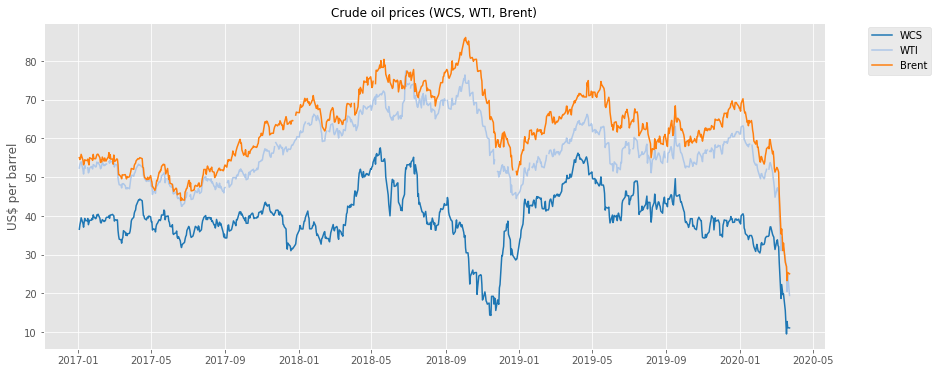

In [4]:
# chart all prices
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(14,6))
ax1.plot(df_prices_all.index, df_prices_all[['WCS', 'WTI', 'Brent']])
ax1.legend(df_prices_all[['WCS', 'WTI', 'Brent']].columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4)
ax1.set_title('Crude oil prices (WCS, WTI, Brent)', fontsize=12)
ax1.set_ylabel('US$ per barrel');

#### 4) Other datasets for crude oil prices
The Alberta government publishes monthly WCS and WTI crude oil prices as part of the Alberta _Economic Dashboard_ report [(link)](https://economicdashboard.alberta.ca/OilPrice). 

The government of Alberta also publishes monthly reference prices for various crude grades produced in Alberta (light oil, medium oil, heavy oil and ultra heavy oil). The _Oil Par Prices_ report is published for the purposes of calculating provincial royalties. Reference prices are calculated based on market indicies at Hardisty and Edmonton, and are adjusted for crude transportation and quality [(link)](https://www.alberta.ca/oil-par-prices.aspx). 

The CER publishes _Crude Oil Annual Export Summary_ report, which includes average export prices [(link)](https://www.cer-rec.gc.ca/nrg/sttstc/crdlndptrlmprdct/stt/crdlsmmr/crdlsmmr-eng.html).

### Gasoline prices

#### 1) Main dataset

Fuel pump prices are obtained via daily surveys of retail gasoline in major centres across Canada. This information is obtained by Kent Group Ltd., with funding from NRCAN [(link)](https://charting.kentgroupltd.com/). Daily prices are available going back to 2016 and weekly prices are available back to 2011.

#### 2) Load dataset

In [5]:
# KENT: daily prices of Unleaded Gasoline, Retail Price including Taxes (in c/Litre) 
url = 'https://charting.kentgroupltd.com/Charting/DownloadExcel?file=/WPPS/Unleaded/Retail%20(Incl.%20Tax)/DAILY/YYYY/Unleaded_Retail%20(Incl.%20Tax)_DAILY_YYYY.xlsx'
# url = 'https://charting.kentgroupltd.com/Charting/DownloadExcel?file=/WPPS/Unleaded/Retail%20(Incl.%20Tax)/MONTHLY/YYYY/Unleaded_Retail%20(Incl.%20Tax)_MONTHLY_YYYY.xlsx'      
   
start_year = 2016
end_year = datetime.datetime.today().year
sheet_name = 'Prices'

# download data one year at a time
data = []
for y in range(start_year, end_year+1):
    header = 0 if y == 2016 else 2
    url_full = url.replace('YYYY', str(y))
    r = requests.get(url_full, allow_redirects=True)
    if r.status_code == requests.codes.ok:
        df = pd.read_excel(io.BytesIO(r.content), sheet_name=sheet_name, header=header, index_col=None)
        df.rename(columns={'Unnamed: 0':'Region'}, inplace=True)
        if 'Average' in df.columns:
            df.drop('Average', axis=1, inplace=True)
        df = pd.melt(df, id_vars=['Region'], var_name='Date', value_name='Price (c/litre)')
        df['Price (c/litre)'] = pd.to_numeric(df['Price (c/litre)'], errors='coerce')
        df.dropna(subset=['Price (c/litre)'], inplace=True)
        df['Date'] = pd.to_datetime(str(y)+'/'+df['Date'])
        data.append(df)
    else:
        print('Error! File could not be downloaded for: ' + url_full)
df_prices_gasoline = pd.concat(data, axis=0, sort=False, ignore_index=True)
df_prices_gasoline['Region'] = df_prices_gasoline['Region'].str.replace('*', '').str.replace('CITY OF ', '').str.replace('Canada Ave(V)', 'CANADA AVERAGE', regex=False)
df_prices_gasoline = pd.pivot_table(df_prices_gasoline, values='Price (c/litre)', index=['Date'], columns=['Region'])

#### 3) Chart dataset

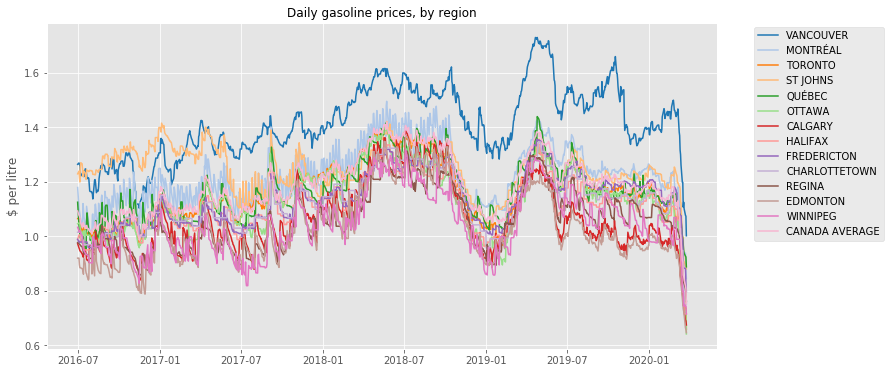

In [6]:
cities = ['VANCOUVER', 'MONTRÉAL', 'TORONTO', 'ST JOHNS', 'QUÉBEC', 'OTTAWA', 'CALGARY', 'HALIFAX', 'FREDERICTON', 
          'CHARLOTTETOWN', 'REGINA', 'EDMONTON', 'WINNIPEG', 'CANADA AVERAGE']

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(12,6))
ax1.plot(df_prices_gasoline.index, df_prices_gasoline[cities]/100)
ax1.legend(df_prices_gasoline[cities].columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4)
ax1.set_title('Daily gasoline prices, by region', fontsize =12)
ax1.set_ylabel('$ per litre');

#### 4) Other datasets for gasoline prices
Statistics Canada publishes _Monthly average retail prices for gasoline and fuel oil, by geography, Table: 18-10-0001-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000101). This report provides monthly average regular unleaded gasoline prices at self service filling stations in major Canadian cities.

### Crude Oil Production

#### 1) Main dataset

Data on the crude oil production is collected by provincial governments and is used to assess the collection of royalties or support regulatory mandates. The CER aggregates provincial government statistics and publishes the _Estimated Production of Canadian Crude Oil and Equivalent_ report [(link)](https://www.cer-rec.gc.ca/nrg/sttstc/crdlndptrlmprdct/stt/stmtdprdctn-eng.html).

Data is available since 2000 and is updated by the CER monthly. Provincial government data may be delayed by up to 6 months. Definition of 'production' is variable between sources.

The CER aggregates the following province-level statistics:
- Government of British Columbia - _Production of crude oil, condensate and Pentanes Plus_ report [(link)](http://www2.gov.bc.ca/gov/content/industry/natural-gas-oil/statistics);

    _Crude Oil Production = BC production only_
    
    _Condensate Production = Wellhead Condensate + Field Condensate + Pentanes Plus_


- Alberta Energy Regulator - _ST3: Alberta Energy Resource Industries Monthly Statistics_ report [(link)](https://aer.ca/providing-information/data-and-reports/statistical-reports/st3);

    _Crude Oil Production = Total Conventional Oil Production_
    
    _Bitumen Production = Non-Upgraded Total + Upgraded Production_
    
    _Condensate Production = Condensate Production + Pentanes Plus Plant Gathering Process + Pentanes Plus Fractionation Yield_


- Government of Saskatchewan – _Crude Oil Volume and Value Summary_ report [(link)](http://publications.saskatchewan.ca/#/products/100415);

    _Crude Oil Production = Production and Recovered Crude Oil Production Volume_


- Statistics Canada - _Supply and Disposition of crude oil and equivalent, monthly Table 25-10-0063-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510006301);


- Canada - Newfoundland Offshore Petroleum Board - _Monthly Production Summary_ report [(link)](https://www.cnlopb.ca/information/statistics/);

    _Crude Production = Monthly Production Totals_


- Government of Northwest Territories Bureau of Statistics _Oil and Gas_ report [(link)](https://www.statsnwt.ca/economy/oil-gas/)

    _Crude Oil Production = Total Oil Production_








#### 2) Load dataset

In [7]:
# access CER's Estimated Production of Canadian Crude Oil and Equivalent report
url_cer = 'https://www.cer-rec.gc.ca/nrg/sttstc/crdlndptrlmprdct/stt/stmtdprdctn-eng.html'
sheet_prod = 'HIST - barrels per day'

r = requests.get(url_cer, allow_redirects=True)
if r.status_code == 200:
    soup = bs(r.content, 'lxml')
    links = soup.find_all('a', attrs={'href': re.compile('^/nrg/sttstc/crdlndptrlmprdct/stt/(.)*.xlsx?')})
    y = 0
    for link in links:
        if y < int(link.get('href').split('.')[-2][-4:]):
            y = int(link.get('href').split('.')[-2][-4:])
            url_prod = 'https://www.cer-rec.gc.ca' + link.get('href')
    # download the latest data in imperial units (million barrels per day)
    df_prod = pd.read_excel(url_prod, sheet_name=sheet_prod, header=0, index_col='Month', parse_dates=['Month']).dropna(1, 'all').dropna(0, 'all') / 1000000
    
    # clean up
    df_prod.columns = df_prod.columns.str.strip()
    df_prod['Non-upgraded Bitumen'] = df_prod['AB non-upgraded']
    df_prod['Upgraded Bitumen'] = df_prod['AB upgraded']
    short_names = {'Raw Mined Bitumen':'MI', 'Raw In Situ Bitumen':'IN', 'Canada Total':'CA', 'Non-upgraded Bitumen':'NO', 'Upgraded Bitumen':'UP'}
    df_prod.rename(columns=short_names, inplace=True)
    df_prod.columns = df_prod.columns.str[:2]
    
    # get province / type totals by grouping
    df_prod = df_prod.groupby(df_prod.columns, axis=1).sum()

    # more clean up
    long_names = {'MI':'Raw Mined Bitumen', 'IN':'Raw In Situ Bitumen', 'NO':'Non-upgraded Bitumen', 'UP':'Upgraded Bitumen', 
                  'AB':'Alberta', 'BC':'British Columbia', 'CA':'Canada', 'MB':'Manitoba', 'NL':'Newfoundland', 
                  'NS':'Nova Scotia', 'NW':'Territories', 'ON':'Ontario', 'SK':'Saskatchewan'}
    df_prod.rename(columns=long_names, inplace=True)
    df_prod.index.rename('Date', inplace=True)
else:
    print('Error! File could not be downloaded from: ' + url)

#### 3) Chart dataset

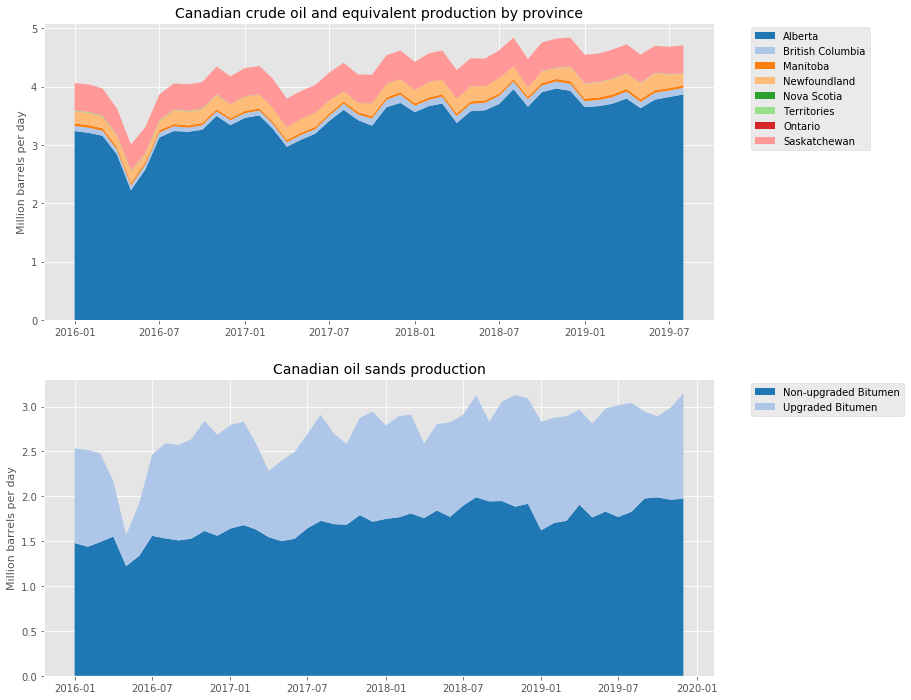

In [8]:
provs = ['Alberta', 'British Columbia', 'Manitoba', 'Newfoundland', 'Nova Scotia', 'Territories', 'Ontario', 'Saskatchewan']
types = ['Non-upgraded Bitumen', 'Upgraded Bitumen']
df_prod_prov = df_prod[(df_prod.index.year >= 2016) & (df_prod['Canada'] > 0)][provs]
df_prod_bit = df_prod[(df_prod.index.year >= 2016) & (df_prod['Non-upgraded Bitumen'] > 0) & (df_prod['Upgraded Bitumen'] > 0)][types]

# create charts for crude oil production
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(12,12))
ax1.stackplot(df_prod_prov.index, df_prod_prov[provs].fillna(0).T)
ax1.set_ylabel('Million barrels per day', fontsize=11)
ax1.set_title('Canadian crude oil and equivalent production by province', fontsize=14)
ax1.legend(df_prod_prov[provs].columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4); 

ax2.stackplot(df_prod_bit.index, df_prod_bit[types].fillna(0).T)
ax2.set_ylabel('Million barrels per day', fontsize=11)
ax2.set_title('Canadian oil sands production', fontsize=14)
ax2.legend(df_prod_bit[types].columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4); 

#### 4) Other datasets for crude oil production

For the provinces of Alberta, British Columbia and Saskatchewan, monthly crude oil production data by operator, well and facility is available from Petrinex [(link)](https://www.petrinex.ca/PD/Pages/default.aspx). Petrinex aggregates detailed production data for crown royalties collection. All public information in the Petrinex database can be obtained from existing sources, including the Alberta Department of Energy, the Alberta Energy Regulator,  the Saskatchewan Ministry of Energy and Resources, the British Columbia Ministry of Finance and the British Columbia Oil and Gas Commission websites or via the Alberta Energy Regulator's Data Dissemination System (DDS).

Monthy crude oil production data is available from Statistics Canada's _Supply and disposition of crude oil and equivalent, Table:25-10-0063-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510006301). Production volumes in the _Supply and disposition of crude oil and equivalent_ report are based on survey and administrative data. 

Annual crude oil production data by sector is available from Statistics Canada’s overall energy balances, _Supply and demand of primary and secondary energy in terajoules Table 25-10-0029-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=2510002901). This report includes data in energy units (terajoules), which allows across fuel comparisons and summation. Statistics Canada also publishes _Supply and demand of primary and secondary energy in natural units Table 25-10-0030-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510003001). This report contains the same data but in natural units, which vary by energy type (litres for liquid fuel, GWh for electricity, etc.) and therefore are not always additive or directly comparable across fuel types [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510003001).

### Crude oil exports

#### 1) Main dataset
The CER regulates the export of crude oil and petroleum products. Holders of export authorizations must report monthly export volumes to the CER. This information is available from the CER's _Commodities Tracking System_ (__[link](https://apps.neb-one.gc.ca/CommodityStatistics/Statistics.aspx?language=english)__) and in flat format from Canada's Open Government website (crude oil - [(link)](https://open.canada.ca/data/en/dataset/0b7bf4b3-423a-45d0-a92b-e69be0b81ce4); refined petroleum products - [(link)](https://open.canada.ca/data/en/dataset/d832ac69-b953-4246-84bc-38cb9dccaff2)). 


#### 2) Load dataset

In [9]:
# access Supply and disposition of crude oil and equivalent report from CER
url_exports_padd = 'https://www.cer-rec.gc.ca/open/imports-exports/crude-oil-exports-by-destination-monthly.csv'
url_exports_type = 'https://www.cer-rec.gc.ca/open/imports-exports/crude-oil-exports-by-type-monthly.csv'

df_exports_padd = pd.read_csv(url_exports_padd, index_col='Period', header=0, parse_dates=['Period']) 
df_exports_padd.index.rename('Date', inplace=True)
df_exports_padd['PADD'] = df_exports_padd['PADD'].str.strip()
df_exports_padd['Volume (millions bbl/d)'] = pd.to_numeric(df_exports_padd['Volume (bbl/d)'], errors='coerce') / 1000000
df_exports_padd = df_exports_padd[df_exports_padd.index.year >= 2016]

df_exports_type = pd.read_csv(url_exports_type, index_col='Period', header=0, parse_dates=['Period'])
df_exports_type.index.rename('Date', inplace=True) 
df_exports_type['Oil Type'] = df_exports_type['Oil Type'].str.strip()
df_exports_type['Volume (millions bbl/d)'] = pd.to_numeric(df_exports_type['Volume (bbl/d)'], errors='coerce') / 1000000
df_exports_type = df_exports_type[df_exports_type.index.year >= 2016]

# get exports by PADD and by oil type (and interpolate any confidential values)
df_exports_padd = df_exports_padd.pivot_table(index='Date', columns='PADD', aggfunc=np.sum)['Volume (millions bbl/d)'].interpolate()
df_exports_type = df_exports_type.pivot_table(index='Date', columns='Oil Type', aggfunc=np.sum)['Volume (millions bbl/d)']

#### 3) Chart dataset

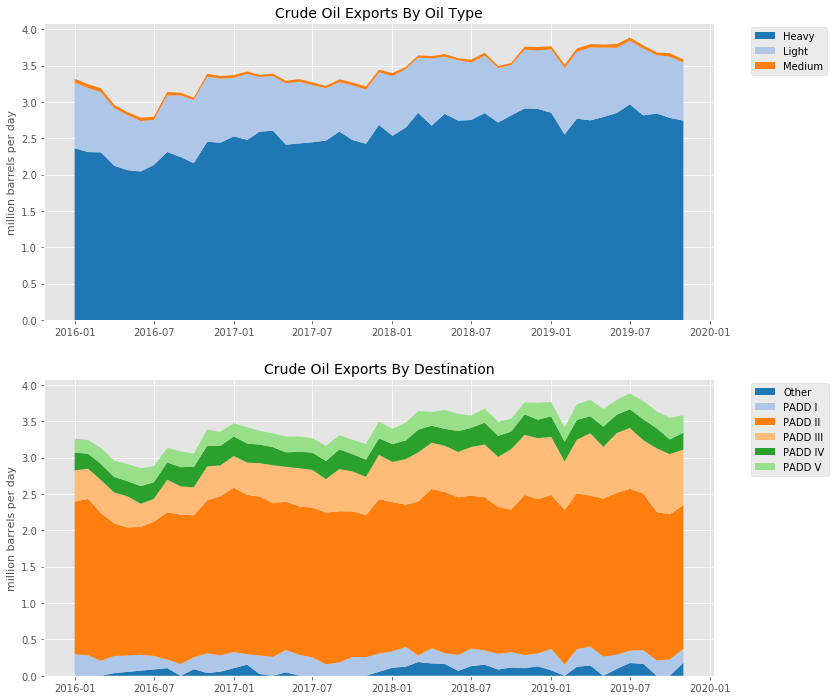

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(12,12))
ax1.stackplot(df_exports_type.index, df_exports_type.drop('Total', 1).T)
ax1.set_ylabel('million barrels per day', fontsize=11)
ax1.set_title('Crude Oil Exports By Oil Type', fontsize=14)
ax1.legend(df_exports_type.drop('Total', 1).columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4);  

ax2.stackplot(df_exports_padd.index, df_exports_padd.drop('Total', 1).T)
ax2.set_ylabel('million barrels per day', fontsize=11)
ax2.set_title('Crude Oil Exports By Destination', fontsize=14)
ax2.legend(df_exports_padd.drop('Total', 1).columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4); 

#### 4) Other datasets for crude oil exports
Data on crude oil exports quantity and values by trading country can also be found in the Canadian International Merchandise and Trade (CIMT) database [(link)](https://www5.statcan.gc.ca/cimt-cicm/home-accueil?lang=eng). This report is based on customs-based trade data, which are derived from the administrative records of the Canadian Border Services Agency and the United States Customs Border Protection. The Harmonized System (HS) code for *crude oil* is 270900 (Crude Petroleum Oils and Oils Obtained from Bituminous Minerals).

Monthy crude oil export data is available from Statistics Canada's _Supply and disposition of crude oil and equivalent, Table:25-10-0063-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510006301). Export volumes in the _Supply and disposition of crude oil and equivalent_ report are based on survey and administrative data. 

Annual crude oil export data is available from Statistics Canada’s overall energy balances, _Supply and demand of primary and secondary energy in terajoules Table 25-10-0029-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=2510002901). This report includes data in energy units (terajoules), which allows across fuel comparisons and summation. Statistics Canada also publishes _Supply and demand of primary and secondary energy in natural units Table 25-10-0030-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510003001). This report contains the same data, but in natural units, which vary by energy type (litres for liquid fuel, GWh for electricity, etc.) and therefore are not always additive or directly comparable across fuel types [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510003001).

CER maintains an interactive visualization that shows quarterly energy trade data between Canada and the U.S. for various energy sources, including crude oil [(link)](https://apps2.cer-rec.gc.ca/imports-exports).

### Crude oil exports by rail
#### 1) Main dataset

CER's publishes the monthly _Canadian Crude Oil Exports by Rail – Monthly Data_ report. Data is available for exports only. Provincial breakdown of this information is not available. Data prior to 2012 is not available for confidentiality reasons [(link)](https://www.neb-one.gc.ca/nrg/sttstc/crdlndptrlmprdct/stt/cndncrdlxprtsrl-eng.html).

#### 2) Load dataset 

In [14]:
# access CER's Canadian Crude Oil Exports by Rail – Monthly Data report 
url_rail = 'https://www.cer-rec.gc.ca/nrg/sttstc/crdlndptrlmprdct/stt/cndncrdlxprtsrl-eng.xlsx'
df_rail = pd.read_excel(url_rail, header=7, usecols='B:G', index_col=None)
df_rail.dropna(0, 'all', subset=df_rail.columns[2:], inplace=True)
df_rail['Year'] = df_rail['Year'].fillna(axis=0, method='ffill')
df_rail.columns = df_rail.columns.str.replace('\n', ' ')
df_rail['Date'] = pd.to_datetime(df_rail['Month'] + ' 1, ' + df_rail['Year'].astype(str), format='%B %d, %Y')
df_rail.set_index('Date', inplace=True)

#### 3) Chart dataset

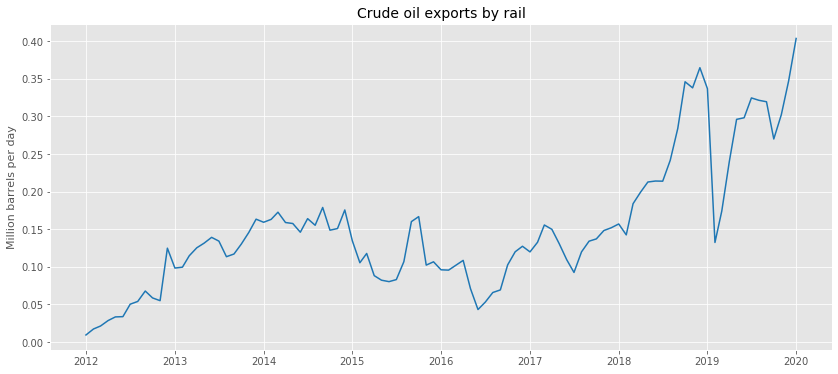

In [15]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(14,6))
ax1.plot(df_rail.index, df_rail['Volume (bbl per day)']/1000000)
ax1.set_ylabel('Million barrels per day', fontsize=11)
ax1.set_title('Crude oil exports by rail', fontsize=14);

### Crude oil imports
Imports of crude oil provide supply for regional Canadian refineries. Refineries in Québec and New Brunswick account for the majority of imported crude oil. Majority of the crude oil imported into Canada comes from the U.S. Unlike exports, the CER does not regulate the imports of crude oil.

#### 1) Main dataset
Data on crude oil imports quantity and values by trading country can also be found in the Canadian International Merchandise and Trade (CIMT) database [(link)](https://www5.statcan.gc.ca/cimt-cicm/home-accueil?lang=eng). This report is based on customs-based trade data, which are derived from the administrative records of the Canadian Border Services Agency and the United States Customs Border Protection. The Harmonized System (HS) code for *crude oil* is 270900 (Crude Petroleum Oils and Oils Obtained from Bituminous Minerals).

#### 2) Load dataset

In [ ]:
# this cell takes about 8 minutes to execute
# CIMT scrape to get 'Petroleum oils and oils, obtained from bituminous minerals, crude', HS Code 270900

# need to change the end date as new data becomes available
date_end = datetime.date.today()
date_start = datetime.date(2016, 1, 1)
dates = pd.date_range(date_start, date_end, freq='MS')

# url to get Imports from StaCan data using HS code
url_imports = ('https://www5.statcan.gc.ca/cimt-cicm/topNCountries-pays?lang=eng&getSectionId()=0&'
       'dataTransformation=0&refYr=YYYY&refMonth=MM&freq=6&countryId=0&getUsaState()=0&'
       'provId=REGION&retrieve=Retrieve&country=null&tradeType=3&topNDefault=250&monthStr=null&'
       'chapterId=27&arrayId=0&sectionLabel=&scaleValue=0&scaleQuantity=0&commodityId=270900')

regions = {'Canada':'1', 'Newfoundland Labrador':'10', 'Prince Edward Is.':'11', 'Nova Scotia':'12', 
           'New Brunswick':'13', 'Quebec':'24', 'Ontario':'35', 'Manitoba':'46', 'Saskatchewan':'47', 
           'Alberta':'48', 'British Columbia':'59', 'Yukon':'60', 'Northwest Terr.':'61', 'Nunavut':'62'}

# download data each region and month at a time
data = []
for r in regions:
    for d in dates:
        get_url = url_imports.replace('REGION',regions[r]).replace('YYYY',str(d.year)).replace('MM',str(d.month))
        try:
            df = pd.read_html(get_url, header=[0, 1, 2], index_col=None, encoding='utf-8')[0]
            df.columns.set_levels(df.columns.levels[0].str.replace(chr(160), ' '), level=0, inplace=True)
            # leave only columns that begin with "Country" or the Date we are downloading
            for col in df.columns:
                if not (col[0].replace(chr(160), ' ').startswith(d.strftime('%B %Y')) or col[0].startswith('Country')):
                    df.drop(col, 1, inplace=True)
            # if there is data
            if len(df.columns) > 0:
                df.columns = df.columns.get_level_values(1)
                df['Region'] = r
                df['Date'] = d
                data.append(df)
        except:
            continue   

# concatenate all the imports data into one dataframe and clean up       
df_imports = pd.concat(data, axis=0, sort=False, ignore_index=True)
df_imports.rename(columns={'Country  (Select a country below to view top  250\xa0trade commodities)':'Country'}, inplace=True)
df_imports['Country'] = df_imports['Country'].str.replace(r'\(.*\)','').str.replace('\d+', '').str.strip()
df_imports['Quantity (million bbl/d)'] = df_imports['Quantity  (MTQ  )'].astype(float) * m3_to_bbl / df_imports['Date'].dt.daysinmonth / 1000000

# filter for imports into Canada and pivot on Country of origin
df_imports_canada = df_imports[(df_imports['Region']=='Canada')].pivot_table(values='Quantity (million bbl/d)', index='Date', columns='Country')

# combine smaller countries into "Other" category
big_countries = ['Algeria', 'Azerbaijan', 'Nigeria', 'Norway', 'Saudi Arabia', 'United States']
countries = [col for col in df_imports_canada if col in big_countries]
df_imports_canada['Other'] = df_imports_canada['World'] - df_imports_canada[countries].sum(axis=1)
countries.append('Other')

# filter for imports from "World" and pivot on destination province of import
df_imports_world = df_imports[(df_imports['Country']=='World')]
df_imports_world = df_imports[(df_imports['Country']=='World')].pivot_table(values='Quantity (million bbl/d)', index=['Date'], columns=['Region'])

#### 3) Chart dataset

In [ ]:
# create charts
ax1 = df_imports_world.drop(columns=['Canada']).plot(kind='bar', stacked=True, figsize=(14,6), width = 0.8)
ax1.set_ylabel('Million barrels per day', fontsize=11)
ax1.set_title('Crude Oil Imports, by Canadian region', fontsize=14)
ax1.legend(df_imports_world.drop(columns=['Canada']).columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4)
ax1.set_xticklabels(df_imports_world.index.to_period('M'));

ax2 = df_imports_canada[countries].plot(kind='bar', stacked=True, figsize=(14,6), width = 0.8)
ax2.set_ylabel('Million barrels per day', fontsize=11)
ax2.set_title('Crude Oil Imports, by source country', fontsize=14)
ax2.legend(df_imports_canada[countries].columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4) 
ax2.set_xticklabels(df_imports_canada.index.to_period('M'));

#### 4) Other sources for crude imports
Monthy crude oil import data is available from Statistics Canada's _Supply and disposition of crude oil and equivalent, Table:25-10-0063-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510006301). Import volumes in the _Supply and disposition of crude oil and equivalent_ report are based on survey and administrative data. 

Annual crude oil import data is available from Statistics Canada’s _Supply and demand of primary and secondary energy in terajoules Table 25-10-0029-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=2510002901). This report includes data in energy units (terajoules), which allows across fuel comparisons and summation. Statistics Canada also publishes _Supply and demand of primary and secondary energy in natural units Table 25-10-0030-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510003001). This report contains the same data but in natural units, which vary by energy type (litres for liquid fuel, GWh for electricity, etc.) and therefore are not always additive or directly comparable across fuel types [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510003001).

CER maintains an interactive visualization that shows quarterly energy trade data between Canada and the U.S. for various energy sources, including crude oil [(link)](https://apps2.cer-rec.gc.ca/imports-exports).

### Refinery consumption 

#### 1) Main dataset

CER publishes the weekly _Weekly Crude Run Summary and Data_ report. Crude runs represent the volume of crude oil consumed by Canadian refineries. The largest refining capacity in Canada is located in central and eastern Canada. The dataset includes all refineries in Canada with the exception of the Sturgeon refinery in Alberta. Data is available going back to 2006 [(link)](https://www.cer-rec.gc.ca/nrg/sttstc/crdlndptrlmprdct/stt/crdrn-eng.html).

#### 2) Load dataset

In [ ]:
# download crude demand by refineries
df_crude_run = pd.read_excel('https://www.cer-rec.gc.ca/nrg/sttstc/crdlndptrlmprdct/stt/crdrn-hstrcl.xlsx', header=7, parse_dates=['Week End / Semaine se terminant le']).dropna(1)
df_crude_run = df_crude_run.pivot_table(values='Runs for the week / Charges pour la semaine', index='Week End / Semaine se terminant le', 
                                        columns='Region (english) / Région (anglais)') * m3_to_bbl / 1000
df_crude_run.index.rename('Date', inplace=True)
df_crude_run['Canada'] = df_crude_run.sum(axis=1)
df_crude_run = df_crude_run[df_crude_run.index.year >= 2016]

#### 3) Chart dataset

In [ ]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(12,6))
ax1.plot(df_crude_run.index, df_crude_run.drop('Canada', 1))
ax1.legend(df_crude_run.drop('Canada', 1).columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4)
ax1.set_title('Weekly Refinery Crude Runs', fontsize =12)
ax1.set_ylabel('Million barrels per day');

#### 4) Other datasets for Canadian refining information
Monthy crude oil inputs to Canadian refineries data is available from Statistics Canada's _Supply and disposition of crude oil and equivalent, Table:25-10-0063-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510006301). Inputs to Canadian refineries data in the _Supply and disposition of crude oil and equivalent_ report is based on survey and administrative data. 

Annual crude oil demand data is available from Statistics Canada’s _Supply and demand of primary and secondary energy in terajoules Table 25-10-0029-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=2510002901). This report includes data in energy units (terajoules), which allows across fuel comparisons and summation. Statistics Canada also publishes _Supply and demand of primary and secondary energy in natural units Table 25-10-0030-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510003001). This report contains the same data but in natural units, which vary by energy type (litres for liquid fuel, GWh for electricity, etc.) and therefore are not always additive or directly comparable across fuel types [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510003001).

Detailed demand data for crude oil and other other energy commodities in available from NRCAN's _Comprehensive Energy Use Database_. The Database provides an overview of energy use in Canada by sector (commercial, residental, industrial, transportation and agriculture) and in each region of the country [(link)](http://oee.nrcan.gc.ca/corporate/statistics/neud/dpa/menus/trends/comprehensive_tables/list.cfm).

### Crude oil supply and demand projection
#### 1) Main dataset
The Canada Energy Regulator publishes the _Energy Futures_ report [(link)](https://www.cer-rec.gc.ca/nrg/ntgrtd/ftr/2019/index-eng.html) - a projection of Canadian energy supply and demand to 2040. The report includes projections for supply and demand of crude oil and refined petroleum products. Projections are modeled based on historical data, and include a series of policy, technology and market assumptions outlined in the report. The report provides data appendices [(link)](https://apps.neb-one.gc.ca/ftrppndc/dflt.aspx?GoCTemplateCulture=en-CA) and interactive visualizations [(link)](https://apps2.cer-rec.gc.ca/dvs/?page=landingPage&language=en) to further explore Canada's energy future. The latest Energy Futures report was published in December 2019.

#### 2) Load dataset

In [ ]:
# access forecast oil production from the Energy Futures report 
url_ef = 'https://www.cer-rec.gc.ca/nrg/ntgrtd/ftr/2019/ccssndxplr/fgrs-eng.xlsx' # 2019 EF
sheet_oil = '12'
df_forecast = pd.read_excel(url_ef, sheet_name=sheet_oil, header=4, index_col=0)

#### 3) Chart dataset

In [ ]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(12,6))
ax1.plot(df_forecast.index, df_forecast)
ax1.set_ylabel('Million barrels per day', fontsize=11)
ax1.set_title('Crude Oil Production Forecast by crude type', fontsize=14)
ax1.legend(df_forecast.columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4);

By 2040, Canadian crude oil production in the Reference Case is projected to average 7 million barrels per day, growing by 49% from 2018. Production is largely located in Alberta, with additional volumes in Saskatchewan and offshore Newfoundland and Labrador. 

#### 4) Other sources for Canadian crude oil production forecasts
The Alberta Energy Regulator publishes the _ST98 Report_, a projection of crude oil production in Alberta [(link)](https://www.aer.ca/providing-information/data-and-reports/statistical-reports/st98). 

At the international level, other government, non-government and corporate entities publish global energy supply and demand statistics, which includes Canada. These include:
- US Energy Information Administration's _International Energy Outlook 2018_ [(link)](https://www.eia.gov/outlooks/ieo/);
- International Energy Agency _World Energy Outlook_ [(link)](https://www.iea.org/weo/);
- Asia Pacific Energy Research Centre’s (APERC) _Energy Demand and Supply Outlook_ [(link)](https://aperc.ieej.or.jp/publications/reports/outlook.php);
- _BP Energy Outlook_ [(link)](https://www.bp.com/en/global/corporate/energy-economics/energy-outlook.html).

## Additional Resources
Please see the Canadian Energy Information Inventory (CEII), a government maintained searchable database for energy-related information and datasets in Canada. The CEII contains links to over 200 datasets related to energy use and production in Canada and is searchable by issuer, commodity and category [(link)](https://public.tableau.com/profile/energy.markets#!/vizhome/CanadianEnergyInformationInventoryCEII-V2_0/Datasets).

All the datasets used in this notebook are listed in the CEII. To provide feedback on the CEII, please email CEII-ICIE@cer-rec.gc.ca.

The Canadian Association of Petroleum Producers publishes the _Statistical Handbook for Canada’s Upstream Petroleum
Industry_. The Handbook is a historical summary of the petroleum industry's progress and summarizes detailed statistical information on prices, drilling, reserves, production and trade [(link)](https://www.capp.ca/publications-and-statistics/statistics/statistical-handbook).  

In [ ]:
authors = ['Margaret Skwara', 'Janna Rodioukova']